<a href="https://colab.research.google.com/github/MaryamNikpasand/Grading/blob/main/Disc/GradingDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import os
import numpy as np
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from scipy import ndimage
from tensorflow.keras import regularizers
from tensorflow.keras import initializers


In [103]:
def read_files(filepath):
  """Read and load volume"""
  # Read file
  scan=plt.imread(filepath)
  # plt.imshow(scan, cmap = plt.cm.gray)
  # plt.show()
  # Get raw data
  return scan

# def normalize(volume):
#   """normalize the volume
#      The max value for normalization is: np.mean(max_all)+2*np.std(max_all)
#      The min value of all images in this dataset is 0
# """
#   min=0
#   max=1007.2348186941014
#   volume[volume<min]=min
#   volume[volume>max]=max
#   volume=(volume-min)/(max-min)
#   volume=volume.astype("float32")
#   return volume

# def normalize(volume):
#   """normalize the volume
#      Normalize with max and min of each image
# """
#   min=np.min(volume)
#   max=np.max(volume)
#   volume=(volume-min)/(max-min)
#   volume=volume.astype("float32")
#   return volume

def normalize(volume):
  """normalize the volume
     Normalize with mean and std of each image
"""
  Mean=np.mean(volume)
  Std=np.std(volume)
  volume=(volume-Mean)/Std
  volume=volume.astype("float32")
  return volume

def resize_volume(img):
  """Resize across z-axis"""
  # Set the desired depth
  desired_width = 64
  desired_height = 64
  # Get current depth
  current_width = img.shape[0]
  current_height = img.shape[-1]
  # Compute depth factor
  width = current_width / desired_width
  height = current_height / desired_height
  width_factor = 1 / width
  height_factor = 1 / height
  # Resize across z-axis
  img = ndimage.zoom(img, (width_factor, height_factor), order=1)
  # resize_and_rescale = tf.keras.Sequential([
  #   layers.experimental.preprocessing.Resizing(desired_width, desired_height, desired_depth)])
  # img = resize_and_rescale(tf.expand_dims(img, axis=-1))
  return img

def process_scan(path):
  """Read and resize volume"""
  # Read scan
  volume=read_files(path)
  # Normalize
  volume=normalize(volume)
  volume=resize_volume(volume)
  volume=tf.expand_dims(volume,axis=-1) #  Adding an extra dimension to the images to have them in (x,x,1) format 
  return volume

In [104]:
filepath = '/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/ImageSelection/Discs/Takahashi/grade1/T2_TSE_SAG__0026_008.ima L4_L5.png'
scan = process_scan(filepath)
scan.shape


TensorShape([64, 64, 1])

In [105]:
# Folder "Disc" consist of MRI scans having Disc images,
Disc_paths = dict()
filepath_Disc='/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/ImageSelection/Discs/Ladd'
for x in os.listdir(filepath_Disc):
    for y in os.listdir(os.path.join(filepath_Disc,x)):
        if x not in Disc_paths:
            Disc_paths[x] = [os.path.join(filepath_Disc, x, y)]
        else:
            Disc_paths[x].append(os.path.join(filepath_Disc, x, y))

print("Disc['grade1']:: " + str(len(Disc_paths['grade1'])))
print("Disc['grade2']:: " + str(len(Disc_paths['grade2'])))
print("Disc['grade3']:: " + str(len(Disc_paths['grade3'])))
print("Disc['grade4']:: " + str(len(Disc_paths['grade4'])))
print("Disc['grade5']:: " + str(len(Disc_paths['grade5'])))

# Read and process the scans.
Disc_grade1 = np.array([process_scan(path) for path in Disc_paths['grade1']])
Disc_grade2 = np.array([process_scan(path) for path in Disc_paths['grade2']])
Disc_grade3 = np.array([process_scan(path) for path in Disc_paths['grade3']])
Disc_grade4 = np.array([process_scan(path) for path in Disc_paths['grade4']])
Disc_grade5 = np.array([process_scan(path) for path in Disc_paths['grade5']])



Disc['grade1']:: 55
Disc['grade2']:: 615
Disc['grade3']:: 1002
Disc['grade4']:: 876
Disc['grade5']:: 85


In [106]:
# For the disc images assign 1-5
Disc_grade1_labels=np.array([[1, 0, 0, 0, 0] for _ in range(len(Disc_grade1))])
Disc_grade2_labels=np.array([[0, 1, 0, 0, 0] for _ in range(len(Disc_grade2))])
Disc_grade3_labels=np.array([[0, 0, 1, 0, 0] for _ in range(len(Disc_grade3))])
Disc_grade4_labels=np.array([[0, 0, 0, 1, 0] for _ in range(len(Disc_grade4))])
Disc_grade5_labels=np.array([[0, 0, 0, 0, 1] for _ in range(len(Disc_grade5))])

Disc_grade1_train_limit=int(len(Disc_paths['grade1'])*.8)
Disc_grade2_train_limit=int(len(Disc_paths['grade2'])*.8)
Disc_grade3_train_limit=int(len(Disc_paths['grade3'])*.8)
Disc_grade4_train_limit=int(len(Disc_paths['grade4'])*.8)
Disc_grade5_train_limit=int(len(Disc_paths['grade5'])*.8)

Disc_grade1_val_limit=int(len(Disc_paths['grade1'])*.1)+Disc_grade1_train_limit
Disc_grade2_val_limit=int(len(Disc_paths['grade2'])*.1)+Disc_grade2_train_limit
Disc_grade3_val_limit=int(len(Disc_paths['grade3'])*.1)+Disc_grade3_train_limit
Disc_grade4_val_limit=int(len(Disc_paths['grade4'])*.1)+Disc_grade4_train_limit
Disc_grade5_val_limit=int(len(Disc_paths['grade5'])*.1)+Disc_grade5_train_limit

# Split data in the ratio 70-30 for training and validation.
x_train=np.concatenate((Disc_grade1[:Disc_grade1_train_limit],
                        Disc_grade2[:Disc_grade2_train_limit],
                        Disc_grade3[:Disc_grade3_train_limit],
                        Disc_grade4[:Disc_grade4_train_limit],
                        Disc_grade5[:Disc_grade5_train_limit]),axis=0)

y_train=np.concatenate((Disc_grade1_labels[:Disc_grade1_train_limit],
                        Disc_grade2_labels[:Disc_grade2_train_limit],
                        Disc_grade3_labels[:Disc_grade3_train_limit],
                        Disc_grade4_labels[:Disc_grade4_train_limit],
                        Disc_grade5_labels[:Disc_grade5_train_limit]),axis=0)

x_val=np.concatenate((Disc_grade1[Disc_grade1_train_limit:Disc_grade1_val_limit],
                      Disc_grade2[Disc_grade2_train_limit:Disc_grade2_val_limit],
                      Disc_grade3[Disc_grade3_train_limit:Disc_grade3_val_limit],
                      Disc_grade4[Disc_grade4_train_limit:Disc_grade4_val_limit],
                      Disc_grade5[Disc_grade5_train_limit:Disc_grade5_val_limit]),axis=0)

y_val=np.concatenate((Disc_grade1_labels[Disc_grade1_train_limit:Disc_grade1_val_limit],
                      Disc_grade2_labels[Disc_grade2_train_limit:Disc_grade2_val_limit],
                      Disc_grade3_labels[Disc_grade3_train_limit:Disc_grade3_val_limit],
                      Disc_grade4_labels[Disc_grade4_train_limit:Disc_grade4_val_limit],
                      Disc_grade5_labels[Disc_grade5_train_limit:Disc_grade5_val_limit]),axis=0)

x_test=np.concatenate((Disc_grade1[Disc_grade1_val_limit:],
                       Disc_grade2[Disc_grade2_val_limit:],
                       Disc_grade3[Disc_grade3_val_limit:],
                       Disc_grade4[Disc_grade4_val_limit:],
                       Disc_grade5[Disc_grade5_val_limit:],),axis=0)

y_test=np.concatenate((Disc_grade1_labels[Disc_grade1_val_limit:],
                       Disc_grade2_labels[Disc_grade2_val_limit:],
                       Disc_grade3_labels[Disc_grade3_val_limit:],
                       Disc_grade4_labels[Disc_grade4_val_limit:],
                       Disc_grade5_labels[Disc_grade5_val_limit:]),axis=0)

print(
    "Number of samples in train, validation and test are %d, %d and %d."
    % (x_train.shape[0], x_val.shape[0],x_test.shape[0])
)

# Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train ))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))


Number of samples in train, validation and test are 2105, 261 and 267.


tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)
tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)
tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)
tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)


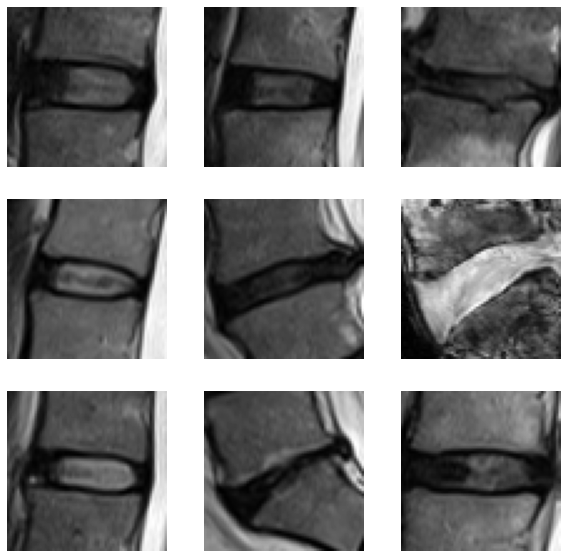

In [107]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

test_dataset = (
    test_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# Visualize a set of images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(images[i].numpy()),cmap='gray')
    print(labels[i])
    # plt.title(int(labels[i]))
    plt.axis("off")



In [ ]:
def get_model_3D_CTscans(hp):
  """Build a 2D convolutional neural network model."""

  image_size=(64,64)
  input_shape = image_size + (1,)
  model = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal"),
                            layers.experimental.preprocessing.RandomRotation(.1)])
  model.add(keras.Input(shape=input_shape))
  model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='valid', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.MaxPool2D(pool_size=2))
  model.add(layers.BatchNormalization())

  for i in range(hp.Int("num_layers", 1, 4)):
    model.add(
          layers.Conv2D(
              # Tune number of filters separately.
              filters=hp.Int(f"filters_{i}",  min_value=32, max_value=512, step=32),
              kernel_size=3,
              activation=hp.Choice("activation", ["relu", "tanh"]),
              kernel_regularizer=regularizers.l1_l2(l1=hp.Float("l1", min_value=1e-5, max_value=1e-4, sampling="log"),
                                                    l2=hp.Float("l2", min_value=1e-5, max_value=1e-4, sampling="log")),        
          ))
    model.add(layers.MaxPool2D(pool_size=2))
    model.add(layers.BatchNormalization())

  model.add(layers.GlobalAveragePooling2D())

  for i in range(hp.Int("num_layers", 1, 3)):
    model.add(
          layers.Dense(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp.Choice("activation", ["relu", "tanh"]),
              kernel_regularizer=regularizers.l2(.001)
          )
     )
  
  if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
  
  model.add(layers.Dense(5, activation="softmax"))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model



model = get_model_3D_CTscans(kt.HyperParameters())
model.build(input_shape=(None, 64, 64, 1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 64, 64, 1)         0         
                                                                 
 random_rotation_2 (RandomRo  (None, 64, 64, 1)        0         
 tation)                                                         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 31, 31, 64)      

In [ ]:
directory = "3D_CTscan" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory

tuner = kt.RandomSearch(
    hypermodel=get_model_3D_CTscans,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="3D_CTscan",
    project_name="DiscGrading",
)

tuner.search_space_summary()


Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
l1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
l2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

Trial 3 Complete [00h 02m 47s]
val_accuracy: 0.760536402463913

Best val_accuracy So Far: 0.777777761220932
Total elapsed time: 00h 11m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in 3D_CTscan/DiscGrading
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
filters_0: 192
activation: relu
l1: 1.0271217651041745e-05
l2: 1.0088750486930079e-05
units_0: 128
dropout: False
lr: 0.0003233648014907526
filters_1: 32
filters_2: 32
units_1: 32
units_2: 32
Score: 0.777777761220932
Trial summary
Hyperparameters:
num_layers: 2
filters_0: 320
activation: tanh
l1: 2.819115101271421e-05
l2: 7.797796350927813e-05
units_0: 160
dropout: True
lr: 0.0008640259802512754
filters_1: 480
filters_2: 128
units_1: 256
units_2: 128
Score: 0.762452095746994
Trial summary
Hyperparameters:
num_layers: 3
filters_0: 64
activation: relu
l1: 2.724469425923319e-05
l2: 8.07815283310992e-05
units_0: 256
dropout: False
lr: 0.0036963795959337816
filters_1: 192
filters_2: 224
units_1: 64
units_2: 512
Score: 0.760536402463913


In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = get_model_3D_CTscans(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
# model.fit(x=x_all, y=y_all, epochs=100)
checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',save_best_only=True)

epochs=100
history=model.fit(
    x=x_all, y=y_all,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)



In [108]:
best_model = keras.models.load_model(checkpoint_path)

In [109]:
best_model.evaluate(test_dataset)


9/9 [==============================] - 0s 6ms/step - loss: 0.2887 - accuracy: 0.7753


[0.2886516749858856, 0.7752808928489685]

In [116]:
fig_path = Path('/content/drive/MyDrive/PhD/Barocas/grading/MyModels/DiscGrade/error_analysis')
it = iter(test_dataset)

ct = 0
for test_item, test_label in it:
  ct+=1
  predicted_label = best_model.predict(test_item)
  diff = (np.round(predicted_label, 0) - test_label).numpy()
  
  for i in range(diff.shape[0]):
    if np.any(diff[i]!=0):
      print(diff[i])
      if np.sum(diff[i])!=0:  # [0, -1, 0, 0, 0] not sure at all (nothing >= 0.5)
        file_name = '4_not_sure'
      else:
        ix_n1 = np.squeeze(np.where(diff[i]==-1))
        ix_p1 = np.squeeze(np.where(diff[i]==+1))
        if np.abs(ix_n1-ix_p1)>1: 
          file_name = '3_very_wrong'  # [0, -1, 0, 1, 0] more than 1 grade wrong
        else:
          if np.any(predicted_label[i]>=0.75): # if confidence in one specific grade is above 75%
            file_name = '1_one_class_wrong_high_confidence'  # [0, -1, +1, 0, 0] exactly 1 grade wrong
          else:
            file_name = '2_one_class_wrong_low_confidence_almost_right'
    
      plt.figure()
      plt.imshow(test_item[i, ..., 0], cmap=plt.cm.gray); plt.axis('off')
      plt.title(f'pred, {np.round(predicted_label[i], 1)} lab, {test_label[i]}')
      plt.savefig(fname = fig_path.joinpath(f'{file_name}_{ct}_{i}.png'))
      plt.close()
      # print(np.round(predicted_label[i], 1))
      # plt.imshow(test_item[i, ..., 0], cmap=plt.cm.gray); plt.axis('off')
      # plt.show()


[ 0  0  0  1 -1]
[ 0  1 -1  0  0]
[ 0 -1  0  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  0  1]
[ 0  1 -1  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0 -1  1  0  0]
[ 0  0  1 -1  0]
[ 0 -1  1  0  0]
[ 0  1 -1  0  0]
[ 0 -1  1  0  0]
[ 0  0  0  1 -1]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[-1  0  0  1  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0 -1  1  0  0]
[ 0  0  1 -1  0]
[-1  0  0  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0 -1  1  0  0]
[ 0  0  0 -1  1]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[ 0  0  0 -1  1]
[ 0  0  1 -1  0]
[ 0  0  1 -1  0]
[-1  1  0  0  0]
[ 0  0  0 -1  1]
[ 0  0 -1  1  0]
[ 0  0  1 -1  0]
[ 0 -1  1  0  0]
[ 0  0 -1  0  0]
[ 0 -1  1  0  0]
[ 0  0  0  1 -1]
[-1  0  0  0  0]
[ 0  0 -1  1  0]
[ 0 -1  1  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0 -1  1  0  0]
[ 0  0  1 -1  0]
[ 0 -1  1  0  0]
[ 0  1 -1  0  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  1 -1  0  0]
[ 0  0 -1  1  0]
[ 0  0 -1  1  0]
[ 0  0  0  1 -1]
[ 0 -1  1  0  0]
[ 0 -1  1  0  0]
[-1  1  0  0  0]
[ 0  0  1 -1  

In [ ]:
fig_path.joinpath(f'4_not_sure_{ct}_{i}.png')

PosixPath('/content/drive/MyDrive/PhD/Barocas/grading/MyModels/DiscGrade/error_analysis/4_not_sure_0_10.png')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


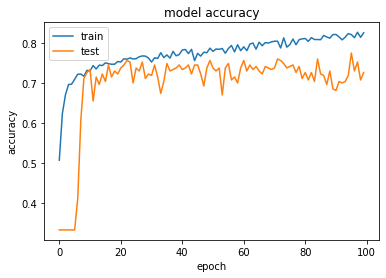

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


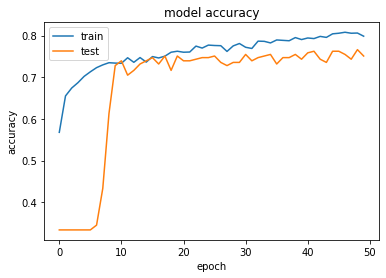

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

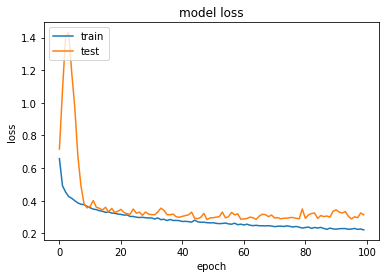

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

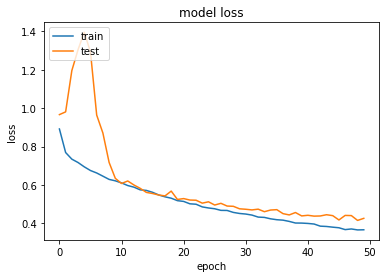

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# %% Model
def get_model_Niemeyer_Paper(input_shape):
#   """Build a 2D convolutional neural network model."""

  inputs = keras.Input(shape=input_shape)
  # Image augmentation
  x=data_augmentation(inputs)

  x=layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.Conv2D(filters=64,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=64,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)    
  x=layers.Dropout(.2)(x)
  x=layers.MaxPool2D(pool_size=2)(x)

  x=layers.Conv2D(filters=128,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=128,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.Conv2D(filters=256,kernel_size=3,dilation_rate=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=256,kernel_size=3,dilation_rate=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)
  x=layers.MaxPool2D(pool_size=2)(x)

  x=layers.Conv2D(filters=512,kernel_size=3,strides=1,padding='valid',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.GlobalAveragePooling2D()(x)
  x=layers.Dense(units=512,activation='relu')(x)

  outputs=layers.Dense(units=5,activation='softmax')(x) #change this to softmax when working wiht gradings

  model=keras.Model(inputs,outputs,name='2dcnn')
  return model

image_size=(64,64)
model=get_model_Niemeyer_Paper(input_shape=image_size + (1,))
model.summary()

Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

In [ ]:
# %% Compile the model
epochs=50
initial_learning_rate=1e-3
num_steps=np.floor(len(x_train)/batch_size)
boundaries=[]
values=[initial_learning_rate]
indx=1
while indx<int(epochs/10):
    boundaries.append(indx*10*num_steps)
    values.append(initial_learning_rate/(10**(indx)))
    indx+=1

# lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries,values)
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=1e5,decay_rate=.96,staircase=True)

model.compile(
    # loss=tf.keras.losses.CategoricalCrossentropy(),
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy'])

# Define callbacks
directory = "Niemeyer_Paper" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory
checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=True
                                              )


history=model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.65517, saving model to /content/Niemeyer_Paper/2d_image_classification.h5
66/66 - 9s - loss: 1.4421 - accuracy: 0.5981 - val_loss: 1.2364 - val_accuracy: 0.6552 - 9s/epoch - 132ms/step
Epoch 2/50

Epoch 00002: val_accuracy did not improve from 0.65517
66/66 - 7s - loss: 0.9520 - accuracy: 0.6527 - val_loss: 0.8267 - val_accuracy: 0.6475 - 7s/epoch - 101ms/step
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.65517 to 0.69732, saving model to /content/Niemeyer_Paper/2d_image_classification.h5
66/66 - 7s - loss: 0.6948 - accuracy: 0.6627 - val_loss: 0.6081 - val_accuracy: 0.6973 - 7s/epoch - 104ms/step
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.69732
66/66 - 7s - loss: 0.5568 - accuracy: 0.6746 - val_loss: 0.5320 - val_accuracy: 0.6245 - 7s/epoch - 106ms/step
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.69732
66/66 - 7s - loss: 0.4938 - accuracy: 0.6675 - val_loss: 0.6240 - val_accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


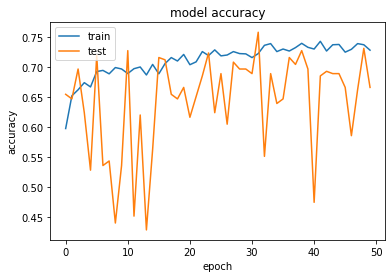

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

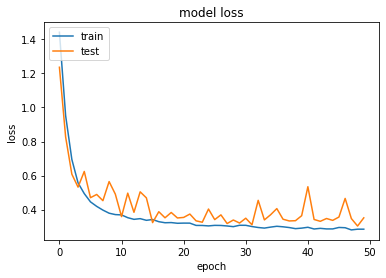

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def get_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size=(64,64)
model = get_model(input_shape=image_size + (1,), num_classes=5)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 1)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 32)   320         ['sequential[2][0]']             
                                                                                                  
 batch_normalization_12 (BatchN  (None, 32, 32, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                

In [ ]:
directory = "classification_from_scratch" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory
checkpoint_path = Path(os.path.join(path,"save_at_{epoch}.h5"))
initial_learning_rate=1e-3

lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=1e5,decay_rate=.96,staircase=True)

epochs = 50

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=True
                                              )

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    callbacks=[checkpoint_cb], 
    validation_data=validation_dataset,
)

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 3.4440 - accuracy: 0.6827
Epoch 00001: val_accuracy improved from -inf to 0.33333, saving model to /content/classification_from_scratch/save_at_1.h5
66/66 [==============================] - 5s 38ms/step - loss: 3.4440 - accuracy: 0.6827 - val_loss: 2.5508 - val_accuracy: 0.3333
Epoch 2/50
65/66 [============================>.] - ETA: 0s - loss: 2.3239 - accuracy: 0.6678
Epoch 00002: val_accuracy improved from 0.33333 to 0.38314, saving model to /content/classification_from_scratch/save_at_2.h5
66/66 [==============================] - 2s 32ms/step - loss: 2.3253 - accuracy: 0.6651 - val_loss: 2.2720 - val_accuracy: 0.3831
Epoch 3/50
65/66 [============================>.] - ETA: 0s - loss: 2.3016 - accuracy: 0.6687
Epoch 00003: val_accuracy did not improve from 0.38314
66/66 [==============================] - 2s 30ms/step - loss: 2.3024 - accuracy: 0.6708 - val_loss: 2.7859 - val_accuracy: 0.3831
Epoch 4/50
65/66 [======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


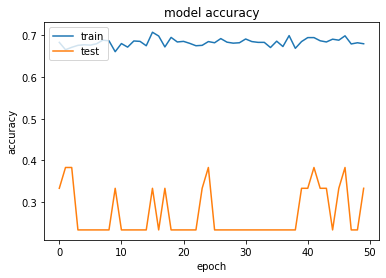

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

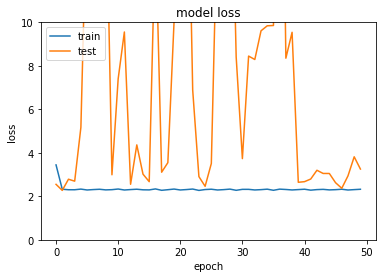

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 10])
plt.show()
